In [2]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import sys
%matplotlib inline

In [3]:
def time_in_seconds(val):
    if "-" in val:
        fields = val.split("-")
        sec=0.0
        for i in fields:
            if "s" in i: sec += float(i.strip("s"))
            if "m" in i: sec += 60 * float(i.strip("m"))
            if "h" in i: sec += 3600 * float(i.strip("h"))
        return sec
    else:
        return float(val.strip("s"))

In [4]:
def parse_report(file_name):
    buffer = []
    resources_dict = {
        "MPI Cores": "mpi", "Threads per core": "thrs", "Threads total": "thr_tot", 
        "Nodes Computing": "nodes", "Nodes IO": "nodes_io", "MPI tasks / GPU": "mpi/gpu",
    }
    resources = {}
    timing = {}
    log = False
    with open(file_name, 'r') as report:
        for line in report:
            if line == "\n": log = False
            if log: 
                buffer.append(line.strip())
            else:
                for key, val in resources_dict.items():
                    if key in line: resources[val] = int(line.strip().split(":")[1])
                if "Time-Profile" in line:
                    timing["Time-Profile"] = time_in_seconds(line.strip().split(":")[1])

            if "Clock:" in line: log = True

    for line in buffer:
        fields = line.split(":")
        timing[fields[0].strip()] = time_in_seconds(fields[1].strip().split()[0])
    return resources, timing

In [5]:
def build_dataframe(x_axis='mpi', factor=1, rename_cols={}):
    r_files = glob("r-*")

    data = {}
    for report in r_files:
        resources, timing = parse_report(report)
        for key, val in resources.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
        for key, val in timing.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
    
    scaling = pd.DataFrame(data)
    if rename_cols: 
        scaling.rename(columns=rename_cols, inplace=True)
    else:
        scaling.rename(columns={'Xo (procedure)': 'Xo', 'X (procedure)': 'X'}, inplace=True)
    scaling.sort_values(by=[x_axis], inplace=True)
    if 'mpi/gpu' in scaling: scaling['gpu'] = pd.Series(scaling['mpi'] / scaling['mpi/gpu'], dtype=np.int64)
    scaling['ideal'] = scaling[x_axis] / factor
    scaling['speedup'] = scaling['Time-Profile'].max() / scaling['Time-Profile']
    scaling['efficiency'] = scaling.speedup / scaling.ideal * 100
    scaling['Self energy'] = scaling['HF'] + scaling['GW(ppa)']
    scaling['Other'] = scaling['Time-Profile'] - scaling['Dipoles'] - scaling['Xo'] - scaling['X'] - scaling['Self energy']
    scaling['node_h'] = scaling['nodes'] * scaling['Time-Profile'] / 3600
    return scaling

In [12]:
def build_scaling_plot(scaling, pile, colors, x_axis='mpi', x_label='MPI tasks', bar_width=1,
                       title=None, legend_loc=None, label=None, label_pos=None, efficiency=True, 
                       file_name='scaling.png', y_lim=None):
    if len(pile) != len(colors):
        sys.stderr.write("Error: the number of elements of pile and colors lists have to be the same.")
        return
    fig, ax1 = plt.subplots(figsize=(10, 7))

    bottom = pd.Series(dtype='float64')
    for key, color in zip(pile, colors):
        if bottom.empty:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key)
            bottom = scaling[key].copy()
        else:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key, bottom=bottom)
            bottom += scaling[key]

    ax1.set_xlabel(x_label,fontsize=20)
    ax1.set_ylabel('Time (sec)',fontsize=20)
    ax1.legend()
    if y_lim: ax1.set_ylim(y_lim)
    if legend_loc: ax1.legend(fontsize='18',framealpha=0.0, loc=legend_loc)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 18)
    if label and label_pos: ax1.text(*label_pos, label, fontsize=20)
    plt.xticks(scaling[x_axis])

    if efficiency:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim([-10, 110])
        ax2.set_ylabel('Efficiency (%)', color='tab:blue',fontsize=20)  # we already handled the x-label with ax1
        ax2.plot(scaling[x_axis], scaling['efficiency'], linewidth=3, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=18)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name, bbox_inches='tight')

In [7]:
def build_cost_plot(scaling, label='yambo', title=None, y_lim=None, file_name='cost.pdf'):
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.set_xlabel('Time to solution (sec)',fontsize=20)
    ax3.set_ylabel('Cost (node*hour)',fontsize=20)
    ax3.plot(scaling['Time-Profile'][2:], scaling['node_h'][2:], 
             linewidth=3, color=colors[0], marker='.', markersize=15,
             label=label)
    if y_lim: ax3.set_ylim(y_lim)
    ax3.legend()
    ax3.legend(fontsize='18',framealpha=0.0)

    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name)

In [8]:
scaling = build_dataframe(x_axis='mpi', factor=20)
scaling.to_csv('scaling.csv', sep='\t')
scaling

mpi  thrs  thr_tot  nodes  nodes_io  mpi/gpu  Time-Profile  \
6   20     8      160      5         1        4        1751.0   
1   40     8      320     10         1        4         986.0   
3   60     8      480     15         1        4         736.0   
2   80     8      640     20         1        4         552.0   
4  100     8      800     25         1        4         469.0   
7  120     8      960     30         1        4         427.0   
8  140     8     1120     35         1        4         385.0   
0  160     8     1280     40         1        4         338.0   
5  200     8     1600     50         1        4         314.0   

   io_ATMPROJ_pwscf  io_KB_abinit   io_BS  ...  DIPOLE_transverse   Dipoles  \
6            0.0000        0.0001  0.0001  ...           574.3177  576.6038   
1            0.0001        0.0001  0.0001  ...           297.3724  299.9611   
3            0.0001        0.0001  0.0002  ...           205.1407  207.5871   
2            0.0001        0.0001  0.0001  ...           157.5548  160.9895   
4            0.0001        0.0001  0.0002  ...           131.2979  137.3013   
7            0.0001        0.0001  0.0002  ...           113.7939  118.8140   
8            0.0001        0.0001  0.0001  ...            97.3707  106.3719   
0            0.0001        0.0001  0.0001  ...            87.6583   93.7193   
5            0.0001        0.0001  0.0001  ...            75.9443   85.7031   

         Xo  gpu  ideal   speedup  efficiency  Self energy    Other    node_h  
6  957.0000    5    1.0  1.000000  100.000000     181.8244  30.7888  2.431944  
1  556.4200   10    2.0  1.775862   88.793103      89.4902  30.7674  2.738889  
3  393.9697   15    3.0  2.379076   79.302536      85.5753  39.2070  3.066667  
2  306.3268   20    4.0  3.172101   79.302536      46.1639  36.0191  3.066667  
4  239.2997   25    5.0  3.733475   74.669510      37.7260  45.5290  3.256944  
7  220.5923   30    6.0  4.100703   68.345043      31.5525  47.4083  3.558333  
8  185.3537   35    7.0  4.548052   64.972171      27.5735  62.3763  3.743056  
0  160.5194   40    8.0  5.180473   64.755917      24.6176  55.9628  3.755556  
5  139.7730   50   10.0  5.576433   55.764331      20.1493  65.2915  4.361111  

[9 rows x 52 columns]

In [9]:
colors=['#2EA6A6', '#F28F38', '#47AB6C', '#112F41', '#D90718']
pile = ['Dipoles', 'Xo', 'X', 'Self energy', 'Other']
scaling[['mpi', 'Time-Profile'] + pile]

mpi  Time-Profile   Dipoles        Xo       X  Self energy    Other
6   20        1751.0  576.6038  957.0000  4.7830     181.8244  30.7888
1   40         986.0  299.9611  556.4200  9.3613      89.4902  30.7674
3   60         736.0  207.5871  393.9697  9.6609      85.5753  39.2070
2   80         552.0  160.9895  306.3268  2.5007      46.1639  36.0191
4  100         469.0  137.3013  239.2997  9.1440      37.7260  45.5290
7  120         427.0  118.8140  220.5923  8.6329      31.5525  47.4083
8  140         385.0  106.3719  185.3537  3.3246      27.5735  62.3763
0  160         338.0   93.7193  160.5194  3.1809      24.6176  55.9628
5  200         314.0   85.7031  139.7730  3.0831      20.1493  65.2915

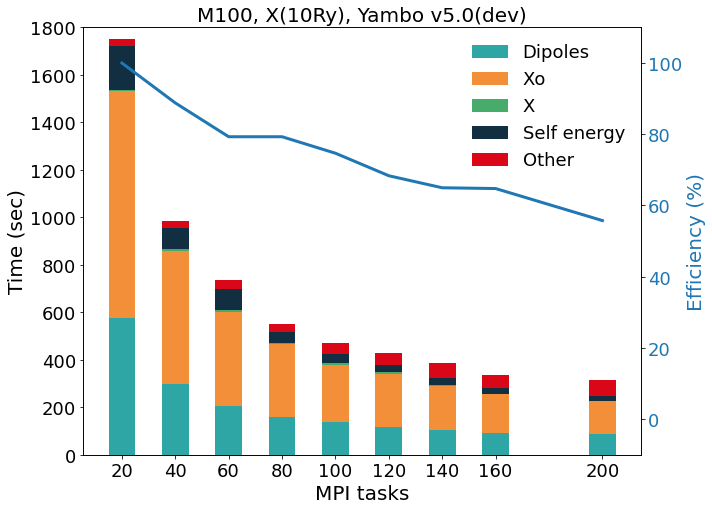

In [13]:
build_scaling_plot(scaling=scaling, 
                   pile=pile, colors=colors, bar_width=10, efficiency=True,
                   legend_loc='upper right', title=r'M100, X(10Ry), Yambo v5.0(dev)', 
                   file_name='scaling_5nodes.png', y_lim=[0,1800])

In [8]:
io_cols=['mpi', 'io_ATMPROJ_pwscf', 'io_KB_abinit', 'io_BS', 'io_Double_Grid', 'io_COL_CUT', 'PP_uspp_init', 'io_HF', 'IO_and_Messaging_switch', 'io_QINDX', 'io_KB_pwscf', 'io_DIPOLES', 'io_fragment', 'io_WF']
scaling[io_cols]

mpi  io_ATMPROJ_pwscf  io_KB_abinit   io_BS  io_Double_Grid  io_COL_CUT  \
6   20            0.0000        0.0001  0.0001          0.0014      0.0186   
1   40            0.0001        0.0001  0.0001          0.0020      0.0003   
3   60            0.0001        0.0001  0.0002          0.0002      0.0018   
2   80            0.0001        0.0001  0.0001          0.0002      0.0007   
4  100            0.0001        0.0001  0.0002          0.0048      0.0003   
7  120            0.0001        0.0001  0.0002          0.0002      0.0310   
8  140            0.0001        0.0001  0.0001          0.0008      0.0003   
0  160            0.0001        0.0001  0.0001          0.0002      0.0110   
5  200            0.0001        0.0001  0.0001          0.0002      0.0201   

   PP_uspp_init   io_HF  IO_and_Messaging_switch  io_QINDX  io_KB_pwscf  \
6        0.0006  0.0251                   0.0005    0.0317       0.4102   
1        0.0006  0.0236                   0.0005    0.0063       0.3825   
3        0.0007  0.1938                   0.0005    0.0155       0.4182   
2        0.0007  0.0225                   0.0005    0.0102       0.4006   
4        0.0007  0.0397                   0.0005    0.0062       0.4695   
7        0.0007  0.0214                   0.0006    0.0097       0.3572   
8        0.0007  0.0254                   0.0005    0.0060       0.3397   
0        0.0007  0.0242                   0.0005    0.0090       0.2022   
5        0.0007  0.0256                   0.0005    0.0078       0.4562   

   io_DIPOLES  io_fragment    io_WF  
6      1.2136       1.9488  12.3918  
1      1.3609       1.1838   7.2857  
3      1.1089      10.9028  24.6600  
2      1.1844       1.0948   5.2042  
4      1.3005       1.5775   4.5782  
7      1.3523       1.2503   3.2316  
8      1.2724       0.9635   3.2361  
0      1.3374       1.0084   3.0669  
5      1.3884       1.1341   3.2734

In [4]:
parse_report('r-rutile_50nodes.out_HF_and_locXC_gw0_rim_cut_em1d_ppa')

({'mpi': 200,
  'thrs': 8,
  'thr_tot': 1600,
  'nodes': 50,
  'nodes_io': 1,
  'mpi/gpu': 4},
 {'Time-Profile': 314.0,
  'io_ATMPROJ_pwscf': 0.0001,
  'io_KB_abinit': 0.0001,
  'io_BS': 0.0001,
  'io_Double_Grid': 0.0002,
  'io_COL_CUT': 0.0201,
  'io_HF': 0.0256,
  'PP_uspp_init': 0.0007,
  'IO_and_Messaging_switch': 0.0005,
  'HF(REDUX)': 0.6496,
  'GW(REDUX)': 1.114,
  'io_QINDX': 0.0078,
  'scatter_Gamp_gpu': 0.0086,
  'io_GROT': 0.066,
  'io_QP_and_GF': 0.0481,
  'io_DIPOLES': 1.3884,
  'io_KB_pwscf': 0.4562,
  'FFT_setup': 0.2099,
  'io_fragment': 1.1341,
  'io_X': 1.0724,
  'MATRIX transfer (X_G_finite_q_X_redux_1_1)': 0.5243,
  'MATRIX transfer (X_G_finite_q_X_redux_1_2)': 0.5158,
  'MATRIX transfer (X_G_finite_q_X_redux_2_2)': 0.5164,
  'MATRIX transfer (X_G_finite_q_X_redux_2_1)': 0.5265,
  'RIM': 1.0641,
  'SERIAL_lin_system_gpu': 1.1385,
  'LINEAR ALGEBRA': 1.1387,
  'X (REDUX)': 2.8891,
  'X (procedure)': 3.0831,
  'io_WF': 3.2734,
  'HF': 2.6406,
  'WF_load_FFT': 4.0521,